# Benchmarking DenseDepth #

OnData sources:
 - [NYU v2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html) -- Default Indoor Set.
 - [Middlebury](https://vision.middlebury.edu/stereo/data/) -- Still Objects.
 - [DIML](https://dimlrgbd.github.io) -- Indoor and Outdoor.

#### Normalize Prediction and Ground Truth ####

Z score normalization applied to both predictions and ground truth.
Standardization was chosen over the min max normalization due to the
latter issues with varying dynamic ranges (distance between min and max pixels)
of the images from different datasets.

In [493]:
import os
import sys
import random
import subprocess

from skimage.transform import resize
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

model_path = "/Users/slava/Downloads/nyu.h5"

The following resize function is used to match dimensions
to the DeepDense NN input/output layer.

In [494]:
# For depth images call with resolution=240
# For color images call with resolution=480
def deepdense_resize(img: np.array, resolution=480, aspect_ratio=4/3) -> np.array:
    return resize(img, (resolution, int(resolution * aspect_ratio)),
                  preserve_range=True, mode='reflect', anti_aliasing=True)

#### NYU Data Loader ####

NYU v2 dataset is available [here](https://drive.google.com/drive/folders/1TzwfNA5JRFTPO-kHMU___kILmOEodoBo).
Download and unzip to proceed with this notebook.

In [495]:
'''
Load NYU Dataset for evaluation.
    Args:
        path - path to nyu dataset test directory.
        count - how many images to load.
        return - a tuple of numpy arrays of rgb and corresponding depth images.
'''
def load_nyu_images(path: str, count=111) -> (np.array, np.array):

    # Collect image path
    rgb_img_path = []
    depth_img_path = []

    with os.scandir(path) as it:
        for entry in it:
            if not entry.name.startswith('.') and entry.is_file():
                if "colors.png" in entry.name:
                    rgb_img_path.append(entry.name)
                elif "depth.png" in entry.name:
                    depth_img_path.append(entry.name)

    rgb_img_path = [path + "/" + name for name in sorted(rgb_img_path)]
    depth_img_path = [path + "/" + name for name in sorted(depth_img_path)]

    rgb_img = [np.clip(np.asarray(Image.open(path), dtype=float) / 255, 0, 1) for path in rgb_img_path[:count]]
    depth_img = [np.asarray(Image.open(path), dtype=float) for path in depth_img_path[:count]]
    depth_img = [1000 / np.clip(1000 * img / np.max(img), 1, 1000) for img in depth_img]
    depth_img = [deepdense_resize(img, 240) for img in depth_img]
    # Normalize and invert depth
    depth_img = [(img - np.mean(img))/np.std(img) for img in depth_img]

    return np.stack(rgb_img), np.stack(depth_img)

#### Middlebury Data Loader ####

Middlebury Dataset is available [here](https://vision.middlebury.edu/stereo/data/scenes2014/).

Evaluation scenes downloaded and unzipped into the folder pointed by argument `path`.
Each sample of images is enclosed in a separate folder as follows:


The following loader method loads the default left view and the corresponding ground truth disparity map.

In [496]:
# Middlebury images to be cropped to the proper aspect ratio 4/3.
def aspect_crop(img: Image, aspect_ratio=4/3) -> np.array:

    img_x, img_y = img.size
    width = min(img_x, img_y * aspect_ratio)
    height = min(img_x / aspect_ratio, img_y)
    left = (img_x - width) // 2
    top = (img_y - height) // 2
    box = (left, top, left + width, top + height)
    return np.asarray(img.crop(box), dtype=float)


def load_middlebury_images(path: str, convert=False) -> (np.array, np.array):

    sample_path = []

    with os.scandir(path) as it:
        for entry in it:
            if not entry.name.startswith('.') and entry.is_dir():
                if "-perfect" in entry.name:
                    sample_path.append(entry.path)

    # Convert .pfm to .png requires magick
    if convert:
        for path in sample_path:
            subprocess.run(["magick", path + "/disp0.pfm", path + "/disp0.png"], check=True)

    rgb_img_path = [path + "/im0.png" for path in sample_path]
    depth_img_path = [path + "/disp0.png" for path in sample_path]

    rgb_img = [np.clip(aspect_crop(Image.open(path)) / 255, 0, 1) for path in rgb_img_path]
    rgb_img = [deepdense_resize(img, 480) for img in rgb_img]

    depth_img = [aspect_crop(Image.open(path)) for path in depth_img_path]
    depth_img = [np.clip(1000 * img / np.max(img), 1, 1000) for img in depth_img]
    depth_img = [deepdense_resize(img, 240) for img in depth_img]

    # Normalize depth
    depth_img = [(img - np.mean(img))/np.std(img) for img in depth_img]

    return np.stack(rgb_img), np.stack(depth_img)

#### DIML Outdoor Data Loader ####

In [497]:
def load_diml_outdoor(path: str, count=111) -> (np.array, np.array):

    # Collect image path
    rgb_img_path = []
    depth_img_path = []

    with os.scandir(path + "/HR/outleft") as it:
        for entry in it:
            if not entry.name.startswith('.') and entry.is_file():
                if ".png" in entry.name:
                    rgb_img_path.append(entry.path)

    with os.scandir(path + "/HR/depthmap") as it:
        for entry in it:
            if not entry.name.startswith('.') and entry.is_file():
                if ".png" in entry.name:
                    depth_img_path.append(entry.path)

    rgb_img = [np.clip(aspect_crop(Image.open(path)) / 255, 0, 1) for path in rgb_img_path[:count]]
    rgb_img = [deepdense_resize(img, 480) for img in rgb_img]

    depth_img = [aspect_crop(Image.open(path)) for path in depth_img_path[:count]]
    depth_img = [np.clip(1000 * img / np.max(img), 1, 1000) for img in depth_img]
    depth_img = [deepdense_resize(img, 240) for img in depth_img]

    # Normalize depth
    depth_img = [-1 * (img - np.mean(img))/np.std(img) for img in depth_img]

    return np.stack(rgb_img), np.stack(depth_img)

#### DIML Indoor Data Loader ####

In [498]:
# Indoor data was organized beforehand into "color" and "depthmap"
# directories from all 18 scenes
def load_diml_indoor(path: str, count=111) -> (np.array, np.array):

    # Collect image path
    rgb_img_path = []
    depth_img_path = []

    with os.scandir(path + "/HR/color") as it:
        for entry in it:
            if not entry.name.startswith('.') and entry.is_file():
                if ".png" in entry.name:
                    rgb_img_path.append(entry.path)

    with os.scandir(path + "/HR/depthmap") as it:
        for entry in it:
            if not entry.name.startswith('.') and entry.is_file():
                if ".png" in entry.name:
                    depth_img_path.append(entry.path)

    rgb_img_path = sorted(rgb_img_path)
    depth_img_path = sorted(depth_img_path)

    rgb_img = [np.clip(aspect_crop(Image.open(path)) / 255, 0, 1) for path in rgb_img_path[:count]]
    rgb_img = [deepdense_resize(img, 480) for img in rgb_img]

    depth_img = [aspect_crop(Image.open(path)) for path in depth_img_path[:count]]
    depth_img = [np.clip(1000 * img / np.max(img), 1, 1000) for img in depth_img]
    depth_img = [deepdense_resize(img, 240) for img in depth_img]

    # Normalize depth
    depth_img = [-1 * (img - np.mean(img))/np.std(img) for img in depth_img]

    return np.stack(rgb_img), np.stack(depth_img)

#### Load Model ####

Get pretrained DeepDense model (~200MB) from [here](https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5).

In [499]:
# Path to the directory containing `layers.py`
sys.path.append("../models")
from densedepth import BilinearUpSampling2D

# Custom object needed for model inference..
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}
model = tf.keras.models.load_model(model_path,
                                   custom_objects=custom_objects,
                                   compile=False)

## Predict NYU Depth ##
Run loaded NYU test images through the model to get predicted depth.

In [500]:
# Load Images
nyu_rgb, nyu_depth = load_nyu_images("/Users/slava/Downloads/nyu_data/data/nyu2_test")

In [501]:
# Predict Depth
nyu_prediction_depth = model.predict(nyu_rgb)

# Normalize Prediction
for i in range(nyu_prediction_depth.shape[0]):
    nyu_prediction_depth[i, ...] = (nyu_prediction_depth[i, ...] - np.mean(nyu_prediction_depth[i, ...]))\
                                    / np.std(nyu_prediction_depth[i, ...])

#### Visualize Prediction ####

Pick a random triple of images from the batch.

In [502]:
#random_index = random.randrange(nyu_prediction_depth.shape[0])
random_index = 10

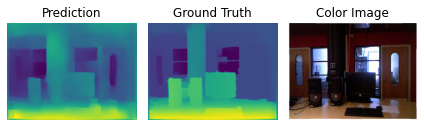

In [503]:
f, axarr = plt.subplots(ncols=3)

for ax in axarr:
    ax.axis("off")

axarr[0].set_title("Prediction")
axarr[0].imshow(nyu_prediction_depth[random_index, :, :, 0])

axarr[1].set_title("Ground Truth")
axarr[1].imshow(10 * nyu_depth[random_index, :, :])

axarr[2].set_title("Color Image")
axarr[2].imshow(nyu_rgb[random_index, :, :])

plt.tight_layout()
plt.savefig("densedepth-nyu.png")
plt.show()

## Predict Middlebury Depth ##

In [504]:
# Load Images
mdbr_rgb, mdbr_depth = load_middlebury_images("/Users/slava/Downloads/middlebury-data")

In [505]:
# Predict Middlebury Depth
mdbr_prediction_depth = model.predict(mdbr_rgb)

In [506]:
# Normalize predicted depth.
for i in range(mdbr_prediction_depth.shape[0]):
    mdbr_prediction_depth[i, ...] = (mdbr_prediction_depth[i, ...] - np.mean(mdbr_prediction_depth[i, ...]))\
                                    / np.std(mdbr_prediction_depth[i, ...])

#### Visualize Prediction ####

Pick a random triple of images from the batch.

In [507]:
#random_index = random.randrange(mdbr_prediction_depth.shape[0])
random_index = 9

Prediction Normalized


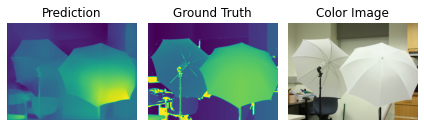

In [508]:
f, axarr = plt.subplots(ncols=3)

for ax in axarr:
    ax.axis("off")

print("Prediction Normalized")
axarr[0].set_title("Prediction")
axarr[0].imshow(mdbr_prediction_depth[random_index, :, :, 0])

axarr[1].set_title("Ground Truth")
axarr[1].imshow(mdbr_depth[random_index, :, :])

axarr[2].set_title("Color Image")
axarr[2].imshow(mdbr_rgb[random_index, :, :])

plt.tight_layout()
plt.savefig("densedepth-mdbr.png")
plt.show()

#### Predict DIML Outdoor ####

In [509]:
diml_o_rgb, diml_o_depth = load_diml_outdoor("/Users/slava/Downloads/diml-outdoor")

In [510]:
# Predict Outdoor DIML Depth
diml_o_prediction_depth = model.predict(diml_o_rgb)

In [511]:
# Normalize predicted depth.
for i in range(diml_o_prediction_depth.shape[0]):
    diml_o_prediction_depth[i, ...] = (diml_o_prediction_depth[i, ...] - np.mean(diml_o_prediction_depth[i, ...]))\
                                    / np.std(diml_o_prediction_depth[i, ...])

#### Visualize Outdoor DIML Prediction ####

Pick a random triple of images from the batch.

In [512]:
#random_index = random.randrange(mdbr_prediction_depth.shape[0])
random_index = 12

Prediction Normalized


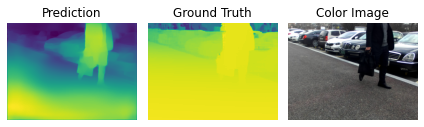

In [513]:
f, axarr = plt.subplots(ncols=3)

for ax in axarr:
    ax.axis("off")

print("Prediction Normalized")
axarr[0].set_title("Prediction")
axarr[0].imshow(diml_o_prediction_depth[random_index, :, :, 0])

axarr[1].set_title("Ground Truth")
axarr[1].imshow(diml_o_depth[random_index, :, :])

axarr[2].set_title("Color Image")
axarr[2].imshow(diml_o_rgb[random_index, :, :])

plt.tight_layout()
plt.savefig("densedepth-diml-o.png")
plt.show()

#### Predict DIML Indoor ####

In [514]:
diml_i_rgb, diml_i_depth = load_diml_indoor("/Users/slava/Downloads/diml-indoor")

In [515]:
# Predict Outdoor DIML Depth
diml_i_prediction_depth = model.predict(diml_i_rgb)

In [516]:
# Normalize predicted depth.
for i in range(diml_i_prediction_depth.shape[0]):
    diml_i_prediction_depth[i, ...] = (diml_i_prediction_depth[i, ...] - np.mean(diml_i_prediction_depth[i, ...]))\
                                    / np.std(diml_i_prediction_depth[i, ...])

#### Visualize Indoor DIML Prediction ####

Pick a random triple of images from the batch.

In [517]:
#random_index = random.randrange(mdbr_prediction_depth.shape[0])
random_index = 13

Prediction Normalized


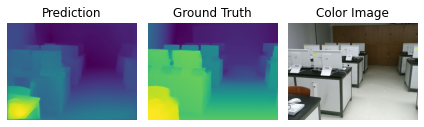

In [518]:
f, axarr = plt.subplots(ncols=3)

for ax in axarr:
    ax.axis("off")

print("Prediction Normalized")
axarr[0].set_title("Prediction")
axarr[0].imshow(diml_i_prediction_depth[random_index, :, :, 0])

axarr[1].set_title("Ground Truth")
axarr[1].imshow(diml_i_depth[random_index, :, :])

axarr[2].set_title("Color Image")
axarr[2].imshow(diml_i_rgb[random_index, :, :])

plt.tight_layout()
plt.savefig("densedepth-diml-i.png")
plt.show()


#### Mean Square Error ####

DIML Indoor MSE 0.3788145459910581
DIML Outdoor MSE 0.7126039565584319
Middlebury MSE: 0.612767244036742
NYU MSE: 0.24538442165379595


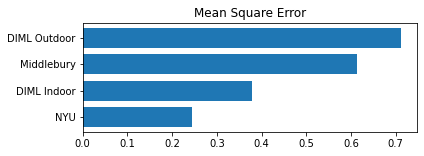

In [519]:
diml_o_mse = np.mean((diml_o_depth - diml_o_prediction_depth[..., 0]) ** 2)
diml_i_mse = np.mean((diml_i_depth - diml_i_prediction_depth[..., 0]) ** 2)
mdbr_mse = np.mean((mdbr_depth - mdbr_prediction_depth[..., 0]) ** 2)
nyu_mse = np.mean((nyu_depth - nyu_prediction_depth[..., 0]) ** 2)

print("DIML Indoor MSE", diml_i_mse)
print("DIML Outdoor MSE", diml_o_mse)
print("Middlebury MSE:", mdbr_mse)
print("NYU MSE:", nyu_mse)

mse = [nyu_mse, diml_i_mse, mdbr_mse, diml_o_mse]
labels = ["NYU", "DIML Indoor", "Middlebury", "DIML Outdoor"]

f, ax = plt.subplots(figsize=(6, 2))

plt.title("Mean Square Error")
plt.barh(y=range(len(mse)), width=mse, height=0.75, tick_label=labels)
plt.show()